# Proyecto Integrador 2020-02

* Arcia Jesus Albero
* Fajardo Daian Paola
* Salazar Carlos Enrique
* Sepulveda Jimenez Hernan

## Importar Librerias

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go 
import folium
import re
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import datetime as dt
#import hdbscan
import seaborn as sns
import scipy.stats as ss
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

plt.style.use('ggplot')

In [2]:
pd.set_option('display.max_row', None)
pd.set_option('display.max_column', None)
pd.set_option("max_colwidth", None)

## Importar DataSet

In [3]:
hurtos_moto = pd.read_csv(r'D:\Universidad\OneDrive - Universidad EAFIT\Ciencia de los datos y analitica\PI2020_2\Data\Raw\hurto_de_moto.csv', 
                          sep = ";", low_memory=False)
hurtos_moto.head()

FileNotFoundError: [Errno 2] File D:\Universidad\OneDrive - Universidad EAFIT\Ciencia de los datos y analitica\PI2020_2\Data\Raw\hurto_de_moto.csv does not exist: 'D:\\Universidad\\OneDrive - Universidad EAFIT\\Ciencia de los datos y analitica\\PI2020_2\\Data\\Raw\\hurto_de_moto.csv'

In [12]:
hurtos_moto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64869 entries, 0 to 64868
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fecha_hecho          64869 non-null  object 
 1   cantidad             64869 non-null  float64
 2   latitud              53231 non-null  float64
 3   longitud             53231 non-null  float64
 4   sexo                 64869 non-null  object 
 5   edad                 64869 non-null  int64  
 6   estado_civil         64869 non-null  object 
 7   grupo_actor          64869 non-null  object 
 8   actividad_delictiva  64869 non-null  object 
 9   parentesco           64869 non-null  object 
 10  ocupacion            64869 non-null  object 
 11  discapacidad         64869 non-null  object 
 12  grupo_especial       64869 non-null  object 
 13  medio_transporte     64869 non-null  object 
 14  nivel_academico      64869 non-null  object 
 15  testigo              64869 non-null 

#### Colocar explicitamente las variables de fecha en el dataset

In [13]:
hurtos_moto['Time'] =  hurtos_moto.fecha_hecho.str.slice(11, 20).astype('datetime64')
hurtos_moto['fecha_hecho'] = hurtos_moto['fecha_hecho'].astype('datetime64')
hurtos_moto['dia'] = hurtos_moto['fecha_hecho'].dt.day
hurtos_moto['mes'] = hurtos_moto['fecha_hecho'].dt.month
hurtos_moto['anho'] = hurtos_moto['fecha_hecho'].dt.year

In [14]:
hurtos_moto.groupby(['anho'])['anho'].count()

anho
2003    4516
2004    3190
2005    2717
2006    2538
2007    2141
2008    2128
2009    3341
2010    2287
2011    4947
2012    5095
2013    4924
2014    4668
2015    4376
2016    5126
2017    3982
2018    4813
2019    4080
Name: anho, dtype: int64

#### Eliminar valores nulos en longitud y latitud

In [15]:
print(f'Before dropping NaNs\t:\tcluster.shape = {hurtos_moto.shape}')
hurtos_moto.dropna(inplace=True)
#cluster.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs\t:\tcluster.shape = {hurtos_moto.shape}')

Before dropping NaNs	:	cluster.shape = (64869, 39)
After dropping NaNs	:	cluster.shape = (53231, 39)


#### Eliminar las variables sin información y errores en el dataset

In [16]:
hurtos_moto.groupby(['unidad_medida,,'])['unidad_medida,,'].count()

unidad_medida,,
Sin dato          2
Sin dato,       418
Sin dato,,    52811
Name: unidad_medida,,, dtype: int64

In [17]:
del hurtos_moto['unidad_medida,,']

#### PreProcessing

In [18]:
hurto_preprocesado = hurtos_moto.copy()

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
hurto_preprocesado['sexo'] = le.fit_transform(hurto_preprocesado['sexo']) # 0 Hombres y 1 Mujeres

In [20]:
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['estado_civil'].unique(), 0)}
hurto_preprocesado['estado_civil'] = hurto_preprocesado['estado_civil'].map(ordinal_label)

In [21]:
hurto_preprocesado['grupo_actor'] = le.fit_transform(hurto_preprocesado['grupo_actor'])
hurto_preprocesado['actividad_delictiva'] = le.fit_transform(hurto_preprocesado['actividad_delictiva'])
hurto_preprocesado['parentesco'] = le.fit_transform(hurto_preprocesado['parentesco'])
hurto_preprocesado['ocupacion'] = le.fit_transform(hurto_preprocesado['ocupacion'])
hurto_preprocesado['discapacidad'] = le.fit_transform(hurto_preprocesado['discapacidad'])
hurto_preprocesado['grupo_especial'] = le.fit_transform(hurto_preprocesado['grupo_especial'])
hurto_preprocesado['nivel_academico'] = le.fit_transform(hurto_preprocesado['nivel_academico'])
hurto_preprocesado['testigo'] = le.fit_transform(hurto_preprocesado['testigo'])
hurto_preprocesado['caracterizacion'] = le.fit_transform(hurto_preprocesado['caracterizacion'])
hurto_preprocesado['articulo_penal'] = le.fit_transform(hurto_preprocesado['articulo_penal'])
hurto_preprocesado['categoria_penal'] = le.fit_transform(hurto_preprocesado['categoria_penal'])
hurto_preprocesado['permiso'] = le.fit_transform(hurto_preprocesado['permiso'])

ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['medio_transporte'].unique(), 0)}
hurto_preprocesado['medio_transporte'] = hurto_preprocesado['medio_transporte'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['conducta'].unique(), 0)}
hurto_preprocesado['conducta'] = hurto_preprocesado['conducta'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['modalidad'].unique(), 0)}
hurto_preprocesado['modalidad'] = hurto_preprocesado['modalidad'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['conducta_especial'].unique(), 0)}
hurto_preprocesado['conducta_especial'] = hurto_preprocesado['conducta_especial'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['arma_medio'].unique(), 0)}
hurto_preprocesado['arma_medio'] = hurto_preprocesado['arma_medio'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['color'].unique(), 0)}
hurto_preprocesado['color'] = hurto_preprocesado['color'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['grupo_bien'].unique(), 0)}
hurto_preprocesado['grupo_bien'] = hurto_preprocesado['grupo_bien'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['categoria_bien'].unique(), 0)}
hurto_preprocesado['categoria_bien'] = hurto_preprocesado['categoria_bien'].map(ordinal_label)

ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['nombre_barrio'].unique(), 0)}
hurto_preprocesado['nombre_barrio'] = hurto_preprocesado['nombre_barrio'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['lugar'].unique(), 0)}
hurto_preprocesado['lugar'] = hurto_preprocesado['lugar'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['sede_receptora'].unique(), 0)}
hurto_preprocesado['sede_receptora'] = hurto_preprocesado['sede_receptora'].map(ordinal_label)
ordinal_label = {k: i for i, k in enumerate(hurto_preprocesado['bien'].unique(), 0)}
hurto_preprocesado['bien'] = hurto_preprocesado['bien'].map(ordinal_label)

hurto_preprocesado['codigo_comuna'] = (hurto_preprocesado['codigo_comuna'].replace('SIN DATO','-1', regex=True).astype(int))

In [22]:
del hurto_preprocesado['codigo_barrio']
del hurto_preprocesado['Time']
del hurto_preprocesado['fecha_hecho']

In [27]:
del hurtos_moto['codigo_barrio']
del hurtos_moto['Time']
del hurtos_moto['fecha_hecho']

In [28]:
hurto_preprocesado.shape, hurtos_moto.shape

((53231, 35), (53231, 35))

# Ingenieria de Caracteristicas

### 1. Filter Methods

##### *Eliminar constantes*

Eliminar esas variables que muestran el mismo valor en todas las observaciones, ya que no muestra información adicional

In [29]:
from sklearn.feature_selection import VarianceThreshold

In [30]:
sel = VarianceThreshold(threshold=0)
sel.fit(hurto_preprocesado)

VarianceThreshold(threshold=0)

In [31]:
sum(sel.get_support())

19

In [32]:
constant_variables = hurto_preprocesado.columns[~sel.get_support()]
len(constant_variables)

16

In [33]:
constant_variables

Index(['cantidad', 'grupo_actor', 'actividad_delictiva', 'parentesco',
       'ocupacion', 'discapacidad', 'grupo_especial', 'nivel_academico',
       'testigo', 'conducta', 'caracterizacion', 'articulo_penal',
       'categoria_penal', 'categoria_bien', 'grupo_bien', 'permiso'],
      dtype='object')

In [34]:
#Remover las constantes
#hurto_preprocesado = sel.transform(hurto_preprocesado)
del hurto_preprocesado['cantidad']
del hurto_preprocesado['grupo_actor']
del hurto_preprocesado['actividad_delictiva']
del hurto_preprocesado['parentesco']
del hurto_preprocesado['ocupacion']
del hurto_preprocesado['discapacidad']
del hurto_preprocesado['grupo_especial']
del hurto_preprocesado['nivel_academico']
del hurto_preprocesado['testigo']
del hurto_preprocesado['conducta']
del hurto_preprocesado['caracterizacion']
del hurto_preprocesado['articulo_penal']
del hurto_preprocesado['categoria_penal']
del hurto_preprocesado['permiso']

In [ ]:
hurtos_moto.drop(['cantidad', 'grupo_actor', 'actividad_delictiva', 'parentesco', 'ocupacion', 'discapacidad', 'grupo_especial', 'nivel_academico', 'testigo', 'conducta', 'caracterizacion', 'articulo_penal', 'categoria_penal', 'permiso'], axis = 1) 

In [35]:
del hurtos_moto['cantidad']
del hurtos_moto['grupo_actor']
del hurtos_moto['actividad_delictiva']
del hurtos_moto['parentesco']
del hurtos_moto['ocupacion']
del hurtos_moto['discapacidad']
del hurtos_moto['grupo_especial']
del hurtos_moto['nivel_academico']
del hurtos_moto['testigo']
del hurtos_moto['conducta']
del hurtos_moto['caracterizacion']
del hurtos_moto['articulo_penal']
del hurtos_moto['categoria_penal']
del hurtos_moto['permiso']

In [36]:
hurto_preprocesado.shape, hurtos_moto.shape

((53231, 21), (53231, 21))

##### *Eliminar quasi-constant*

In [37]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(hurto_preprocesado) #Encuentra las caracteristicas con poca varianza

VarianceThreshold(threshold=0.01)

In [38]:
sum(sel.get_support()) #True: Caracteristicas con gran variabilidad, False: Caracteristicas con poca variablidad (quasi-constant)

16

In [39]:
quasi_constant = hurto_preprocesado.columns[~sel.get_support()]
len(quasi_constant)

5

In [40]:
quasi_constant

Index(['latitud', 'longitud', 'bien', 'categoria_bien', 'grupo_bien'], dtype='object')

In [41]:
hurtos_moto['bien'].value_counts() / np.float(len(hurtos_moto))

Moto          0.999568
Moto carro    0.000319
Cuatrimoto    0.000113
Name: bien, dtype: float64

In [42]:
hurtos_moto['categoria_bien'].value_counts() / np.float(len(hurtos_moto))

Vehículos de 2 o 4 ruedas    1.0
Name: categoria_bien, dtype: float64

In [43]:
hurtos_moto['grupo_bien'].value_counts() / np.float(len(hurtos_moto))

Vehículo    1.0
Name: grupo_bien, dtype: float64

In [44]:
#hurto_preprocesado = sel.transform(hurto_preprocesado)
del hurto_preprocesado['categoria_bien']
del hurto_preprocesado['grupo_bien']

In [45]:
del hurtos_moto['categoria_bien']
del hurtos_moto['grupo_bien']

In [46]:
hurto_preprocesado.shape, hurtos_moto.shape

((53231, 19), (53231, 19))

##### *Duplicates variables*

In [47]:
hurto_preprocesado_t = pd.DataFrame(hurto_preprocesado.T) # Columnas son filas
hurto_preprocesado_t.duplicated().sum() #Buscar los duplicados

0

In [48]:
hurto_preprocesado_t[hurto_preprocesado_t.duplicated()] #Visualizar los duplicados

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,287,289,290,292,294,295,296,297,300,303,304,307,308,309,312,313,314,315,316,317,318,319,320,322,323,324,325,326,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,347,352,353,354,356,357,358,359,360,361,363,364,365,366,367,368,374,380,381,382,383,384,385,386,387,388,389,390,391,392,394,395,397,398,402,406,407,408,409,410,411,412,417,418,419,420,421,426,427,428,429,430,437,438,439,440,441,442,443,444,451,452,453,454,455,456,457,458,462,463,464,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,514,515,516,517,518,520,521,522,523,524,527,528,529,530,533,534,535,536,541,542,543,544,545,550,551,552,553,554,555,556,557,558,559,560,562,563,565,566,569,570,573,574,578,579,583,584,588,589,590,591,592,593,594,598,599,600,601,602,603,604,608,609,610,611,612,613,614,615,616,620,621,622,623,624,625,626,627,628,631,632,633,634,635,636,639,640,641,642,643,644,647,648,649,650,651,654,655,656,657,658,660,661,662,663,665,666,667,668,671,672,673,674,675,678,679,680,681,682,685,686,689,690,694,698,701,702,705,706,709,710,713,714,716,717,719,720,721,722,723,724,725,726,731,732,733,734,735,736,741,742,743,744,745,746,751,752,757,758,760,761,762,764,765,766,769,770,773,774,777,778,779,780,783,784,785,786,787,788,789,790,791,792,794,795,796,797,798,800,801,802,803,804,809,810,811,816,817,818,822,823,827,828,831,832,833,834,835,836,837,838,839,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,867,868,869,870,873,874,875,876,880,881,882,883,887,888,889,890,892,893,895,896,900,901,902,906,907,908,912,913,914,915,916,917,921,922,923,924,925,926,927,928,931,932,935,936,937,938,940,941,942,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,965,966,967,968,969,970,971,972,973,974,975,976,977,980,981,982,983,984,985,986,987,990,991,994,995,996,997,998,1000,1001,1002,1003,1004,1005,1006,1008,1009,1010,1011,1012,1013,1014,1021,1022,1023,1024,1031,1032,1033,1034,1037,1038,1039,1042,1043,1044,1046,1047,1048,1049,1051,1052,1053,1054,1057,1058,1059,1060,1061,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1084,1085,1089,1090,1092,1093,1094,1095,1096,1097,1098,1100,1101,1102,1103,1104,1105,1106,1110,1111,1112,1113,1114,1115,1119,1120,1121,1122,1123,1124,1127,1128,1129,1132,1133,1134,1141,1142,1143,1144,1145,1152,1153,1154,1155,1156,1157,1158,1159,1160,1165,1166,1167,1168,1173,1174,1175,1176,1180,1181,1185,1186,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1216,1222,1224,1226,1230,1231,1235,1236,1238,1239,1240,1242,1243,1244,1250,1251,1252,1253,1254,1260,1261,1262,1263,1264,1268,1269,1270,1271,1272,1276,1277,1278,1279,1280,1283,1284,1285,1286,1289,1290,1291,1292,1301,1302,1311,1312,1315,1316,1317,1318,1319,1320,1323,1324,1325,1326,1327,1328,1330,1331,1332,1333,1335,1336,1337,1338,1343,1344,1

In [49]:
duplicated_features = hurto_preprocesado_t[hurto_preprocesado_t.duplicated()].index.values
duplicated_features = pd.DataFrame(duplicated_features)

In [50]:
data_unique = duplicated_features.drop_duplicates(keep='first').T # Eliminar lod duplicados
data_unique.shape # Volver el dataset como estaba anteriormente

(1, 0)

In [51]:
duplicated_features = [col for col in pd.DataFrame(duplicated_features).columns if col not in data_unique.columns] #Identificar los duplicados antes de ser eliminados. 
duplicated_features 

[0]

In [52]:
hurto_preprocesado.shape, hurtos_moto.shape

((53231, 19), (53231, 19))

No hay variables duplicadas.

##### *Correlacion*

Correlación de variables categoricas con la función cramers

In [62]:
hurtos_moto2 = hurtos_moto[['sexo','edad','estado_civil','medio_transporte','modalidad','conducta_especial','arma_medio','nombre_barrio','codigo_comuna','lugar','sede_receptora','bien','modelo','color','anho','dia']].copy()
n_filas, n_columnas = hurtos_moto2.shape

def cramers_v(x,y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

matriz_corr = np.zeros((n_columnas,n_columnas))
names = hurtos_moto2.columns

In [64]:
i = 0
j = 0
for x in names:
    j = 0
    for k in names:
        def_y = cramers_v(hurtos_moto2[x],hurtos_moto2[k])
        matriz_corr[j][i] = def_y
       # print(matriz_corr)
        j = j + 1
    i = i + 1

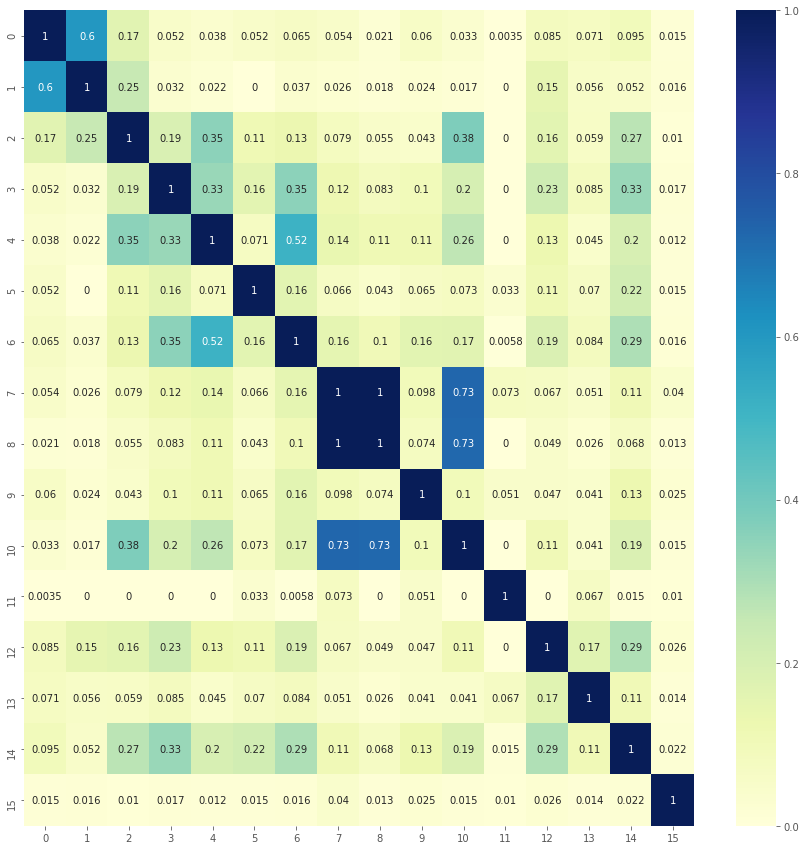

In [65]:
plt.figure(figsize=(15,15))
sns.heatmap(matriz_corr, annot=True, cmap='YlGnBu')

Correlación con funcion corr

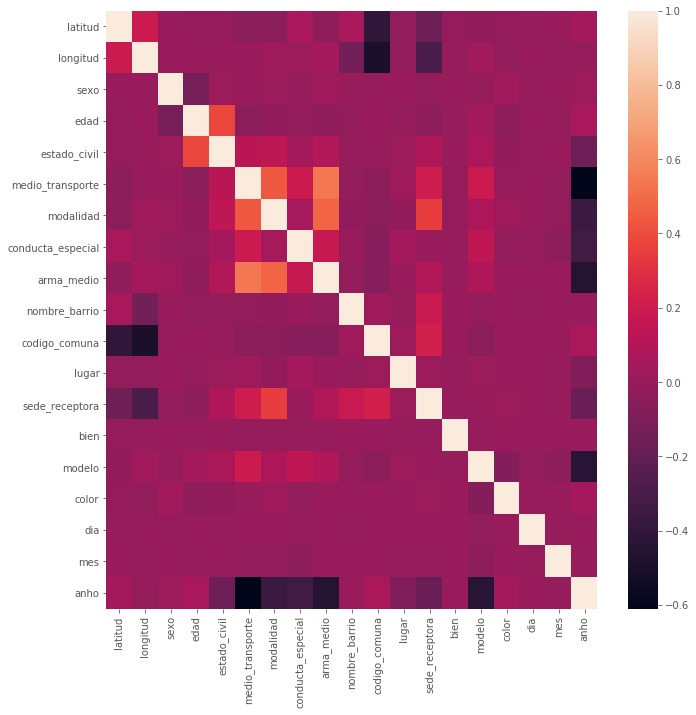

In [66]:
corrmat = hurto_preprocesado.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat)

Correlación por el metodo Brute force

In [67]:
def correlation(dataset, threshold):
    col_corr = set() #conjunto de todos los nombres de las columnas correlacionadas
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [71]:
corr_features = correlation(hurto_preprocesado, 0.8)
len(set(corr_features))

0

En este caso no hay variables con una correlación alta

In [72]:
#Para eliminar las variables correlacionadas
hurto_preprocesado.drop(labels=corr_features, axis=1, inplace=True)
hurtos_moto.drop(labels=corr_features, axis=1, inplace=True)

In [73]:
hurto_preprocesado.shape, hurtos_moto.shape

((53231, 19), (53231, 19))

Correlación con pearson corr coefficient 

In [74]:
corrmat = hurto_preprocesado.corr()
corrmat = corrmat.abs().unstack() #Valor absoluto del coeficiente de correlación 
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr


In [75]:
#Encontrar los grupos de caracteristicas correlacionadas
grouped_features_ls = []
correlated_group = []

for features in corrmat.feature1.unique():
    if features not in grouped_feature_ls:
        
        #Encontrar las caractersticas correlacionadas
        correlatd_block = corrmat[corrmat.feature1 == feature]
        grouped_features_ls = grouped_features_ls + list(correlated_block.feature2.unique()) + [feature]
        
        correlated_group.append(correlatd_block)

print("Se encontro {} grupos correlacionados".format(len(correlated_group)))
print("{} Es el total de caracteristicas no correlacionadas".format(hurto_preprocesado.shape[1]))

Se encontro 0 grupos correlacionados
19 Es el total de caracteristicas no correlacionadas


In [76]:
#Con el siguiente codigo se puede visualizar los grupos correlacionados
for group in correlated_group:
    print(group)
    print()

#### Dataset no supervisado

*El siguiente dataset puede ser utilizado para clusterización ya que se realizo un preprocesamiento y selección de caracteristicas basico (para modelos no supervisados)*

In [77]:
hurto_preprocesado_cluster = hurto_preprocesado.copy()
hurtos_moto_cluster = hurtos_moto.copy()

### 2. Statistical Mesuraments

#### Dataset supervisado

*El siguiente dataset puede ser utilizado para predicción (para modelos supervisados)*

In [78]:
hurto_preprocesado_predic = hurto_preprocesado_cluster.copy()
hurtos_moto_predic = hurtos_moto_cluster.copy()

##### *Mutual Information*

Revisar la dependiencia de dos variables

$I(X;Y) = \sum_{y\epsilon Y} \sum_{x\epsilon X} {p(X,Y)} (x,y) log (\frac{p(X,Y) (x,y)}{pX(x) pY(y)})$

Si X y Y son independientes entonces este sera igual a 0, 
Si x es deterministico de Y enotonces X sera diferente de 0

In [79]:
x = hurto_preprocesado_predic.drop(['modalidad'], axis=1)
y = hurto_preprocesado_predic[["modalidad"]]

In [80]:
mi = mutual_info_classif(x, y)
mi #Nos muestra mutual information de cada caracteristica contra el objetivo 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.09866038, 0.10873701, 0.0013995 , 0.00594803, 0.14657991,
       0.37286645, 0.05288312, 0.63496448, 0.07549848, 0.02936479,
       0.07170237, 0.20404002, 0.        , 0.08676041, 0.0105895 ,
       0.00160905, 0.00158216, 0.15687179])

Text(0, 0.5, 'Mutual Information')

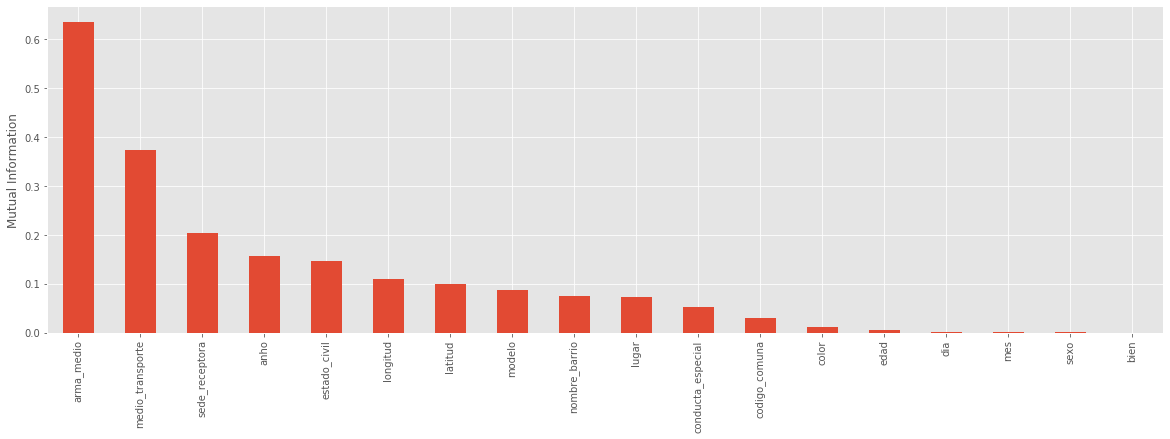

In [81]:
mi = pd.Series(mi)
mi.index = x.columns
mi.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

In [82]:
mi.sort_values(ascending=False)

arma_medio           0.634964
medio_transporte     0.372866
sede_receptora       0.204040
anho                 0.156872
estado_civil         0.146580
longitud             0.108737
latitud              0.098660
modelo               0.086760
nombre_barrio        0.075498
lugar                0.071702
conducta_especial    0.052883
codigo_comuna        0.029365
color                0.010589
edad                 0.005948
dia                  0.001609
mes                  0.001582
sexo                 0.001399
bien                 0.000000
dtype: float64

Las variables que aportar mayor predicción contra la modalidad de hurto. Como lo es el arma y medio transporte.Y tambien se puede ver a la derecha de la grafica existen unos caracteristicas que no le estan aportando predicción al modelo.
Para efectos del modelo se eliminaran esas variables que se encuentran con un aporte de información del 0.05%

In [83]:
del hurto_preprocesado_predic['mes']
del hurto_preprocesado_predic['bien']
del hurto_preprocesado_predic['dia']
del hurto_preprocesado_predic['edad']
del hurto_preprocesado_predic['sexo']
del hurto_preprocesado_predic['color']
del hurto_preprocesado_predic['codigo_comuna']

In [84]:
del hurtos_moto_predic['mes']
del hurtos_moto_predic['bien']
del hurtos_moto_predic['dia']
del hurtos_moto_predic['edad']
del hurtos_moto_predic['sexo']
del hurtos_moto_predic['color']
del hurtos_moto_predic['codigo_comuna']

##### *Chi Square*

El Chi-Cuadrado es una prueba estadística, más adecuada para determinar una diferencia entre las frecuencias esperadas y las frecuencias observadas en una o más categorías de una tabla de contingencia. 

$X2 = \sum \frac{(Observed - Expected)^2} {Expected}$

In [ ]:
### 2. Wrapper Methods

##### *Step Forward Feature Selection*

In [ ]:
#!pip install mlxtend

In [97]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [103]:
hurto_preprocesado_predic.head()

,latitud,longitud,estado_civil,medio_transporte,modalidad,conducta_especial,arma_medio,nombre_barrio,lugar,sede_receptora,modelo,anho
0,6.268040,-75.549892,0,0,0,0,0,0,0,0,2014,2017
1,6.290076,-75.556893,1,1,1,0,1,1,0,1,2005,2017
2,6.304187,-75.551760,1,0,0,0,0,2,0,1,2011,2017
3,6.248002,-75.574849,2,1,1,1,2,3,1,2,-1,2017
4,6.268129,-75.557882,0,0,0,0,0,4,2,3,2015,2017


In [120]:
hurto_preprocesado.columns

Index(['latitud', 'longitud', 'sexo', 'edad', 'estado_civil',
       'medio_transporte', 'modalidad', 'conducta_especial', 'arma_medio',
       'nombre_barrio', 'codigo_comuna', 'lugar', 'sede_receptora', 'bien',
       'modelo', 'color', 'dia', 'mes', 'anho'],
      dtype='object')

In [125]:
namesX = ['latitud', 'longitud', 'sexo', 'edad', 'estado_civil',
       'medio_transporte', 'conducta_especial', 'arma_medio',
       'nombre_barrio', 'codigo_comuna', 'lugar', 'sede_receptora', 'bien',
       'modelo', 'color', 'dia', 'mes', 'anho']

x = hurto_preprocesado[namesX]
y = hurto_preprocesado['modalidad']

In [165]:
model1 = Pipeline([('randomF', RandomForestClassifier())])

params = {'randomF__n_estimators':(100,150,200),
          'randomF__criterion':(["gini", "entropy"]),
          'randomF__min_samples_split':(2,5,10)
#           'random__max_features':(["auto","sqrt", "log2"])
         }


In [166]:
grid1 = GridSearchCV(model1, params, cv=5)

In [ ]:
grid1.fit(x,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [160]:
grid1.best_score_

0.8579629848130839

In [161]:
grid1.best_params_

{'randomF__criterion': 'entropy', 'randomF__n_estimators': 200}

In [87]:
sfs1 = SFS(RandomForestClassifier (n_jobs=4), #Seleccionar las variables con random forest y con 4 procesadore
          k_features = 19, #Se quiere seleccionar el numeor de caracteristicas
          forward = True,
          floating = False, 
          verbose = 2, 
          scoring = 'roc_auc', #Basados en roc auc
          cv = 3) #Cross Validation

In [92]:
corrmat = hurto_preprocesado.corr()
corrmat = corrmat.abs().unstack() #Valor absoluto del coeficiente de correlación 
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.1]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head(5)

,feature1,feature2,corr
0,anho,medio_transporte,0.609903
1,medio_transporte,anho,0.609903
2,arma_medio,medio_transporte,0.545426
3,medio_transporte,arma_medio,0.545426
4,longitud,codigo_comuna,0.499834


In [94]:
hurto_sfs = hurto_preprocesado.copy()
del hurto_sfs['codigo_comuna']

In [93]:
sfs1 = sfs1.fit(np.array(hurto_sfs.fillna(0)), hurto_preprocesado['codigo_comuna'])

AttributeError: k_features must be a positive integer between 1 and X.shape[1], got 19

In [91]:
hurto_preprocesado.head()

,latitud,longitud,sexo,edad,estado_civil,medio_transporte,modalidad,conducta_especial,arma_medio,nombre_barrio,codigo_comuna,lugar,sede_receptora,bien,modelo,color,dia,mes,anho
0,6.268040,-75.549892,0,29,0,0,0,0,0,0,3,0,0,0,2014,0,1,1,2017
1,6.290076,-75.556893,0,22,1,1,1,0,1,1,2,0,1,0,2005,1,1,1,2017
2,6.304187,-75.551760,0,23,1,0,0,0,0,2,2,0,1,0,2011,2,1,1,2017
3,6.248002,-75.574849,0,-1,2,1,1,1,2,3,10,1,2,0,-1,3,1,1,2017
4,6.268129,-75.557882,0,34,0,0,0,0,0,4,4,2,3,0,2015,3,1,1,2017


In [ ]:
count_modalidad = pd.value_counts(hurtos_moto['modalidad'], sort = True)
count_modalidad.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frecuencia de la Etiqueta")
plt.xlabel("Etiqueta")
plt.ylabel("Numero de Observaciones")

In [ ]:
cluster = hurtos_moto[['longitud','latitud','nombre_barrio','year','month','day','Time']].copy()

In [ ]:
cluster.isna().values.any()

In [ ]:
print(f'Before dropping NaNs and dupes\t:\tcluster.shape = {cluster.shape}')
cluster.dropna(inplace=True)
#cluster.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tcluster.shape = {cluster.shape}')

In [ ]:
#cluster1 = cluster[(cluster.year == '2017') & (cluster.month == '01')].copy()
cluster1 = cluster[cluster.year == '2017'].copy()

In [ ]:
X = np.array(cluster1[['longitud', 'latitud']], dtype='float64')

In [ ]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

### Visualizando Geograficamente la data

In [ ]:
m = folium.Map(location=[cluster1.latitud.mean(), cluster1.longitud.mean()], zoom_start=13, 
               tiles='Stamen Toner')
for _, row in cluster1.iterrows():
    folium.CircleMarker(
        location=[row.latitud, row.longitud],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.nombre_barrio),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)
m

### K-Means Clustering

In [ ]:
X = np.array(cluster1[['longitud','latitud']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
cluster1[f'CLUSTER_kmeans{k}'] = class_predictions

In [ ]:
cluster1.head()

In [ ]:
cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

def create_map(cluster1, cluster_column):
    m = folium.Map(location=[cluster1.latitud.mean(), cluster1.longitud.mean()], zoom_start=13, tiles='Stamen Toner')
    
    for _, row in cluster1.iterrows():
        
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]
        
        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=5,
            popup=row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(cluster1, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

In [ ]:
m

In [ ]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

In [ ]:
X = np.array(cluster1[['longitud','latitud']], dtype='float64')
k = 5
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
cluster1[f'CLUSTER_kmeans{k}'] = class_predictions

In [ ]:
def create_map(cluster1, cluster_column):
    m = folium.Map(location=[cluster1.latitud.mean(), cluster1.longitud.mean()], zoom_start=13, tiles='Stamen Toner')
    
    for _, row in cluster1.iterrows():
        
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]
        
        folium.CircleMarker(
            location=[row['latitud'], row['longitud']],
            radius=5,
            popup=row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(cluster1, 'CLUSTER_kmeans5')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_5.html')
m

### DBSCAN

In [ ]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

cluster1['CLUSTERS_DBSCAN'] = class_predictions

In [ ]:
m = create_map(cluster1, 'CLUSTERS_DBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

In [ ]:
m

### HDSCAN

In [ ]:
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2, cluster_selection_epsilon=0.01)

class_predictions = model.fit_predict(X)
cluster1['CLUSTER_HDBSCAN'] = class_predictions

In [ ]:
m = create_map(cluster1, 'CLUSTER_HDBSCAN')

print(f'Number of clusters found: {len(np.unique(class_predictions))-1}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

m

In [ ]:
hdbscan.HDBSCAN?

### Addresing New Points

In [ ]:
classifier = KNeighborsClassifier(1)

In [ ]:
df_train = cluster1[cluster1.CLUSTER_HDBSCAN!=-1]
df_predict = cluster1[cluster1.CLUSTER_HDBSCAN==-1]

In [ ]:
X_train = np.array(df_train[['longitud','latitud']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'], dtype='float64')

X_predict = np.array(df_predict[['longitud','latitud']], dtype='float64')

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
predictions = classifier.predict(X_train)

In [ ]:
cluster1['CLUSTER_hybrid'] = cluster1['CLUSTER_HDBSCAN']

In [ ]:
cluster1.loc[cluster1.CLUSTER_HDBSCAN==-1, 'CLUSTER_hybrid'] = predictions

In [ ]:
m = create_map(cluster1, 'CLUSTER_hybrid')

In [ ]:
m

In [ ]:
class_preditions = cluster1.CLUSTER_hybrid

In [ ]:

print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

In [ ]:
cluster1['CLUSTER_hybrid'].value_counts().plot.hist(bins=70, alpha=0.4, label='Hybrid')
cluster1['CLUSTER_kmeans70'].value_counts().plot.hist(bins=70, alpha=0.4, label='K-Means 70')

plt.legend()
plt.title('Comparing Hybrid & K-Means Approaches')
plt.xlabel('Cluster Sizes')